# imports

In [77]:
import os
import torch
import json
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import random
from collections import Counter

# set the device

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# set hyperparameters

In [ ]:
#TODO

# Vocabulary

In [ ]:
# TODO: complete it

# Download with: python -m spacy download en
spacy_eng = spacy.load("en_core_web_sm")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<Start>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def create_wordmap():
        # TODO: complete and correct and use it
        word_freq = Counter()
        
        for cap in captions:
            # Update word frequency
            word_freq.update(cap['tokens'])

        words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
        self.stoi.update({k: v + 1 for v, k in enumerate(words)})
        self.itos.update({v + 1: k for v, k in enumerate(words)})

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# load data

In [65]:
class ImageCaptionDataset(Dataset):
    def __init__(self, image_folder, captions_dict, transform=None):
        self.image_folder = image_folder
        self.captions_dict = captions_dict  # Dictionary with {image_name: [caption1, caption2, ...]}
        self.captions = [caption for captions in captions_dict.values() for caption in captions] # all captions together
        self.caption_lengths = [len(caption.split()) for caption in self.captions]
        self.image_names = list(captions_dict.keys())  # List of unique image names
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_folder, image_name)

        # Open image
        image = Image.open(image_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Get all captions for the image
        captions = self.captions_dict[image_name]

        return image, captions

In [66]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

image_folder = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"  
karpathy_json_path = "/kaggle/input/karpathy-splits/dataset_flickr30k.json" 

In [67]:
# Load Karpathy split JSON
with open(karpathy_json_path, "r") as f:
    data = json.load(f)

# Organize images by split
split_data = {"train": {}, "val": {}, "test": {}}

for img in data["images"]:
    image_name = img["filename"]
    split = img["split"]  # Can be "train", "val", or "test"
    
    captions = [sent["raw"] for sent in img["sentences"]]  # Extract all 5 captions


    
    tokens = [caption["tokens"] for caption in captions]  # Extract all tokens


    
    split_data[split][image_name] = captions  # Store in respective split

# Now we have:
# split_data["train"], split_data["val"], split_data["test"]


In [68]:
# Load different splits
train_dataset = ImageCaptionDataset(image_folder, split_data["train"], transform=transform)
val_dataset = ImageCaptionDataset(image_folder, split_data["val"], transform=transform)
test_dataset = ImageCaptionDataset(image_folder, split_data["test"], transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [69]:
# Test the dataloader
# Fetch one batch
images, captions = next(iter(train_loader))

print(f"Batch Size: {len(images)}")
print(f"Image Tensor Shape: {images.shape}")  # Should be [batch_size, 3, 224, 224]
print(f"First Caption: {captions[0]}")

Batch Size: 4
Image Tensor Shape: torch.Size([4, 3, 256, 256])
First Caption: ('A man wearing a red uniform and helmet stands on his motorbike.', 'Several people walking or sitting outside in a large city.', 'En exotic young lady looks perplexed while speaking with an older gentleman.', 'A girl with a white backpack is standing and smaller children are sitting in a row on the ground.')


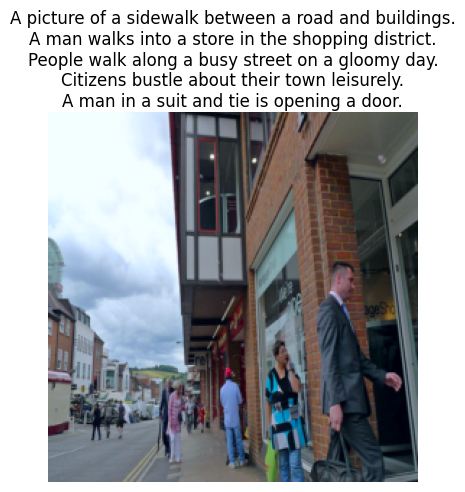

In [76]:
# Visualize a sample
def show_sample(dataset, idx):
    image, caption = dataset[idx]
    image = image.permute(1, 2, 0).numpy()
    image = image * 0.225 + 0.45  # De-normalize
    wrapped_caption = "\n".join(caption)
    plt.imshow(image)
    plt.title(wrapped_caption, fontsize=12, wrap=True)
    plt.axis('off')
    plt.show()

show_sample(train_dataset, random.randint(0, len(train_dataset)))

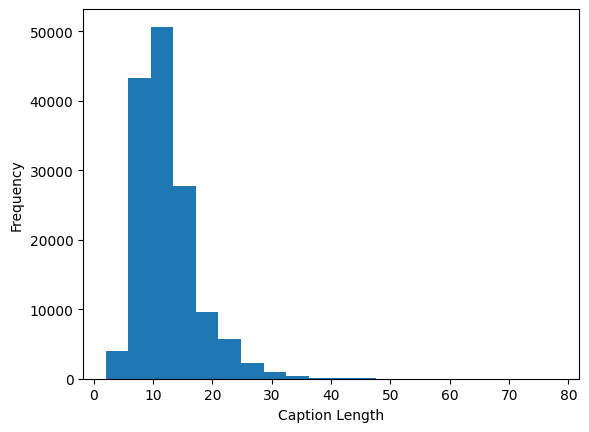

In [73]:
# Caption Length Analysis
caption_lengths = train_dataset.caption_lengths
plt.hist(caption_lengths, bins=20)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


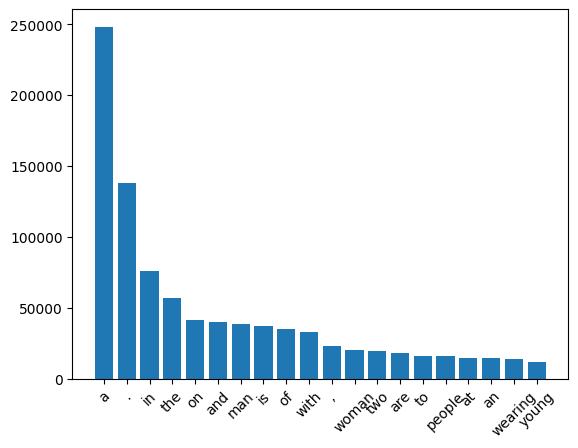

In [74]:
# Word Frequency
all_captions = [caption for caption in train_dataset.captions]

nltk.download('punkt')
all_words = nltk.tokenize.word_tokenize(" ".join(all_captions).lower())
word_freq = Counter(all_words)

# Plot top 20 words
plt.bar(*zip(*word_freq.most_common(20)))
plt.xticks(rotation=45)
plt.show()

# visualize data

# model

# train

# validate

# test on new data

# TTS

# Save outputs for next time

In [5]:
!zip -r saved_data.zip /kaggle/working/

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/WORDMAP.json (deflated 7%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
